In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation,BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D

from keras.utils.generic_utils import get_custom_objects
from keras.optimizers import RMSprop, adam

from keras.utils import np_utils, plot_model
from keras.callbacks import ReduceLROnPlateau, CSVLogger,TensorBoard, ModelCheckpoint

from keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [2]:
(X_train, y_train),(X_test,y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0],28,28,1).astype('float32')
X_test = X_test.reshape(X_test.shape[0],28,28,1).astype('float32')

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

num_classes = y_test.shape[1]

In [3]:
#Normalization
X_train = X_train/255.0
X_test = X_test/255.0

In [4]:
seed = 7

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,
                                                  test_size=0.2,                    
                                                  random_state=seed)
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)

(48000, 28, 28, 1)
(12000, 28, 28, 1)
(48000, 10)
(10000, 10)


In [6]:
class Swish(Activation):
    
    def __init__(self, activation, **kwargs):
        super(Swish, self).__init__(activation, **kwargs)
        self.__name__ = 'Swish_s'

def swish(x):
    return K.sigmoid(x)*x

In [7]:
def cnn_model():
    model = Sequential()
    get_custom_objects().update({'Swish_s': Swish(swish)})
    model.add(Conv2D(32,(7,7), input_shape=(28,28,1), kernel_initializer='he_uniform',activation='Swish_s'))
    model.add(BatchNormalization())
    
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    
    model.add(Conv2D(32,(5,5), kernel_initializer='he_uniform',activation='Swish_s'))
    model.add(BatchNormalization())
    
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    
    model.add(Conv2D(32,(3,3), kernel_initializer='he_uniform',activation='Swish_s'))
    model.add(BatchNormalization())
    
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    
    model.add(Flatten())
    
    model.add(Dense(128, activation='selu',kernel_initializer='he_normal'))
    model.add(Dense(10,activation='selu',kernel_initializer='he_normal'))
    model.add(Dense(num_classes,activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    return model

In [8]:
cnn_model = cnn_model()
print(cnn_model.summary())
plot_model(cnn_model, to_file='swish_activation_cnn.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 22, 22, 32)        1600      
_________________________________________________________________
batch_normalization_1 (Batch (None, 22, 22, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          25632     
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 32)          128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 32)          9248      
__________

In [9]:
if not (os.path.isdir("logs")):
    os.makedirs('logs')


tb = TensorBoard(log_dir='logs', 
                 histogram_freq=0.2, 
                 batch_size=32, 
                 write_graph=True, 
                 write_grads=True, 
                 write_images=True, 
                 embeddings_freq=0, 
                 embeddings_layer_names=None, 
                 embeddings_metadata=None)

csv_logger = CSVLogger('log.csv', append=True, separator=',')

checkpointer = ModelCheckpoint(filepath='swish_activation_conv2d_weights.hdf5',verbose=1, save_best_only=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                           patience=3,
                                           verbose=1,
                                           factor=0.2,
                                           min_lr=0.001)

In [10]:
#with out data augmentation

history = cnn_model.fit(X_train, y_train,
          batch_size=64, 
          epochs=100, 
          verbose=1, 
          validation_data=(X_val, y_val),
          callbacks=[csv_logger,tb,checkpointer,learning_rate_reduction])

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 44s - loss: 0.2299 - acc: 0.9342 - val_loss: 0.0846 - val_acc: 0.9748
Epoch 2/100
48000/48000 [==============================] - 30s - loss: 0.0665 - acc: 0.9798 - val_loss: 0.0671 - val_acc: 0.9807
Epoch 3/100
48000/48000 [==============================] - 30s - loss: 0.0456 - acc: 0.9865 - val_loss: 0.0522 - val_acc: 0.9855
Epoch 4/100
48000/48000 [==============================] - 30s - loss: 0.0332 - acc: 0.9893 - val_loss: 0.0489 - val_acc: 0.9856
Epoch 5/100
48000/48000 [==============================] - 30s - loss: 0.0280 - acc: 0.9911 - val_loss: 0.0527 - val_acc: 0.9854
Epoch 6/100
48000/48000 [==============================] - 30s - loss: 0.0222 - acc: 0.9925 - val_loss: 0.0519 - val_acc: 0.9859
Epoch 7/100
48000/48000 [==============================] - 31s - loss: 0.0179 - acc: 0.9941 - val_loss: 0.0475 - val_acc: 0.9868
Epoch 8/100
48000/48000 [======================

48000/48000 [==============================] - 30s - loss: 0.0037 - acc: 0.9988 - val_loss: 0.0507 - val_acc: 0.9902
Epoch 32/100
48000/48000 [==============================] - 30s - loss: 0.0039 - acc: 0.9988 - val_loss: 0.0577 - val_acc: 0.9892
Epoch 33/100
48000/48000 [==============================] - 30s - loss: 0.0044 - acc: 0.9987 - val_loss: 0.0743 - val_acc: 0.9858
Epoch 34/100
48000/48000 [==============================] - 30s - loss: 0.0050 - acc: 0.9983 - val_loss: 0.0517 - val_acc: 0.9911
Epoch 35/100
48000/48000 [==============================] - 30s - loss: 0.0048 - acc: 0.9985 - val_loss: 0.0532 - val_acc: 0.9888
Epoch 36/100
48000/48000 [==============================] - 30s - loss: 0.0033 - acc: 0.9989 - val_loss: 0.0555 - val_acc: 0.9897
Epoch 37/100
48000/48000 [==============================] - 30s - loss: 0.0035 - acc: 0.9989 - val_loss: 0.0544 - val_acc: 0.9894
Epoch 38/100
48000/48000 [==============================] - 30s - loss: 0.0042 - acc: 0.9988 - val_loss

48000/48000 [==============================] - 31s - loss: 0.0022 - acc: 0.9993 - val_loss: 0.0560 - val_acc: 0.9907
Epoch 65/100
48000/48000 [==============================] - 31s - loss: 0.0030 - acc: 0.9991 - val_loss: 0.0587 - val_acc: 0.9905
Epoch 66/100
48000/48000 [==============================] - 30s - loss: 0.0024 - acc: 0.9992 - val_loss: 0.0573 - val_acc: 0.9911
Epoch 67/100
48000/48000 [==============================] - 30s - loss: 0.0015 - acc: 0.9995 - val_loss: 0.0528 - val_acc: 0.9921
Epoch 68/100
48000/48000 [==============================] - 30s - loss: 0.0015 - acc: 0.9997 - val_loss: 0.0643 - val_acc: 0.9902
Epoch 69/100
48000/48000 [==============================] - 30s - loss: 0.0023 - acc: 0.9993 - val_loss: 0.0713 - val_acc: 0.9892
Epoch 70/100
48000/48000 [==============================] - 30s - loss: 0.0028 - acc: 0.9992 - val_loss: 0.0710 - val_acc: 0.9880
Epoch 71/100
48000/48000 [==============================] - 30s - loss: 0.0031 - acc: 0.9989 - val_loss

48000/48000 [==============================] - 30s - loss: 0.0013 - acc: 0.9996 - val_loss: 0.0628 - val_acc: 0.9902
Epoch 97/100
48000/48000 [==============================] - 30s - loss: 0.0024 - acc: 0.9993 - val_loss: 0.0593 - val_acc: 0.9903
Epoch 98/100
48000/48000 [==============================] - 30s - loss: 0.0026 - acc: 0.9993 - val_loss: 0.0701 - val_acc: 0.9897
Epoch 99/100
48000/48000 [==============================] - 30s - loss: 0.0011 - acc: 0.9996 - val_loss: 0.0631 - val_acc: 0.9918
Epoch 100/100
48000/48000 [==============================] - 30s - loss: 0.0018 - acc: 0.9994 - val_loss: 0.0732 - val_acc: 0.9904


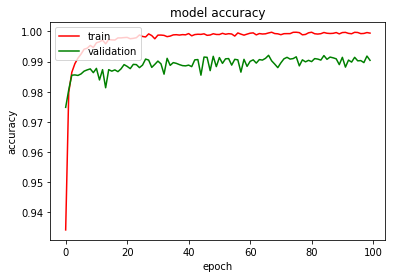

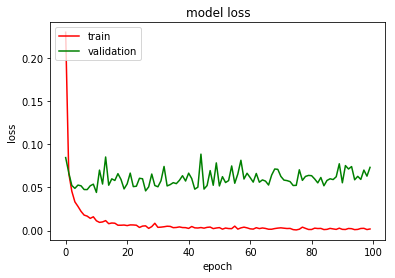

In [11]:
plt.plot(history.history['acc'],color='r')
plt.plot(history.history['val_acc'],color='g')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'],color='r')
plt.plot(history.history['val_loss'],color='g')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [12]:
y_pred_onehotencoded = cnn_model.predict(X_val)
y_pred = np.argmax(y_pred_onehotencoded,axis=1)
y_true = np.argmax(y_val,axis=1)
print(X_val.shape,y_pred.shape,y_true.shape)

(12000, 28, 28, 1) (12000,) (12000,)


In [13]:
confusion_mtx = confusion_matrix(y_true,y_pred)
print (confusion_mtx)

[[1139    1    0    1    0    0    3    0    0    0]
 [   1 1334    1    2    0    1    1    3    0    0]
 [   1    2 1118    2    1    0    0    2    3    0]
 [   0    0    0 1236    0    6    0    0    0    2]
 [   1    5    0    0 1186    0    3    2    0    1]
 [   1    0    0    1    0 1099    2    0    0    8]
 [   1    1    1    1    1    4 1192    0    0    0]
 [   0    2    0    0    2    0    0 1286    0    3]
 [   2    7    0    3    0    6    0    0 1176    7]
 [   3    0    1    1    8    0    0    2    2 1119]]


In [14]:
results = cnn_model.predict(X_test)
results = np.argmax(results, axis=1)
y_test_ = np.argmax(y_test,axis=1)
res_confusion_mtx = confusion_matrix(y_test_,results)
print(res_confusion_mtx)

[[ 976    0    0    0    0    0    2    1    1    0]
 [   2 1129    0    3    0    0    0    1    0    0]
 [   1    2 1020    0    2    0    0    6    1    0]
 [   0    0    0 1004    0    5    0    1    0    0]
 [   0    0    0    0  976    0    3    0    0    3]
 [   0    0    0    3    0  883    2    0    0    4]
 [   3    1    0    1    1    1  950    0    1    0]
 [   0    3    1    0    1    0    0 1017    0    6]
 [   0    0    0    3    1    1    0    3  965    1]
 [   1    0    0    0    6    2    0    1    0  999]]


In [21]:
print("\nTEST ACCURACY IS {}%".format(cnn_model.evaluate(X_test,y_test)[1]*100))

 9984/10000 [============================>.] - ETA: 0s
TEST ACCURACY IS 99.19%
